In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline


In [5]:
df_player = pd.read_csv('data/historical_RAPTOR_by_player.csv')
print('df_player cols :  ' ,  df_player.columns)

df = df_player[['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_total','war_total', 'pace_impact']]


df_player cols :   Index(['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_offense',
       'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season',
       'war_playoffs', 'predator_offense', 'predator_defense',
       'predator_total', 'pace_impact'],
      dtype='object')



 war_total = 'Wins Above Replacement — how many wins the player adds compared to a "replacement-level" player.
  this will be our target

 mp = minutes played

 poss = possesions in season

 raptor_offense: The player’s offensive Raptor rating — an advanced stat estimating offensive impact per 100 possessions.

 raptor_defense: Defensive Raptor rating — impact on defense per 100 possessions.

 raptor_total: Total Raptor rating — combines offense and defense for an overall impact metric.
 
 pace_impact = Impact on the team’s pace — how much the player influences the speed of the game

In [6]:
print(df.head(7))
print('shape = ', df.shape)

           player_name  player_id  season  poss    mp  raptor_total  \
0       Alaa Abdelnaby  abdelal01    1991   640   303     -4.448526   
1       Alaa Abdelnaby  abdelal01    1992  1998   959     -2.751792   
2       Alaa Abdelnaby  abdelal01    1993  2754  1379     -4.443544   
3       Alaa Abdelnaby  abdelal01    1994   320   159     -8.888368   
4       Alaa Abdelnaby  abdelal01    1995   984   506     -5.114556   
5  Kareem Abdul-Jabbar  abdulka01    1977  7674  3483      7.647899   
6  Kareem Abdul-Jabbar  abdulka01    1978  5343  2399      6.871064   

   war_total  pace_impact  
0  -0.265191     0.199241  
1  -0.006893     0.485436  
2  -1.227189     0.488266  
3  -0.500600     0.511152  
4  -0.615802     1.545922  
5  18.488255    -0.502962  
6  11.688727    -0.566163  
shape =  (18553, 8)


In [7]:
df.nunique()


player_name      3442
player_id        3464
season             45
poss             6415
mp               3598
raptor_total    18553
war_total       18550
pace_impact     18542
dtype: int64

There are more ids than names. Each row is a player in a distinct season:
a good identifier for each case will be player_id. 

There is certainly a dependence between the same player at different seasons: perhaps the season feature will help us take that into account.

In [8]:

df = df[['player_id', 'season', 'poss', 'mp','raptor_total', 'war_total', 'pace_impact']]
df

,player_id,season,poss,mp,raptor_total,war_total,pace_impact
0,abdelal01,1991,640,303,-4.448526,-0.265191,0.199241
1,abdelal01,1992,1998,959,-2.751792,-0.006893,0.485436
2,abdelal01,1993,2754,1379,-4.443544,-1.227189,0.488266
3,abdelal01,1994,320,159,-8.888368,-0.500600,0.511152
4,abdelal01,1995,984,506,-5.114556,-0.615802,1.545922
...,...,...,...,...,...,...,...
18548,zubaciv01,2017,1305,609,-6.398767,-1.141160,0.644128
18549,zubaciv01,2018,871,410,-0.214877,0.531968,0.311576
18550,zubaciv01,2019,2345,1079,-0.548676,1.217134,0.077074
18551,zubaciv01,2020,3447,1646,4.649308,6.224207,-0.410164


# Missing or NaN values

In [9]:
# nan values
print(df.isna().sum())

# row where we nan value
print(df[df['pace_impact'].isna()])

player_id       0
season          0
poss            0
mp              0
raptor_total    0
war_total       0
pace_impact     1
dtype: int64
       player_id  season  poss  mp  raptor_total  war_total  pace_impact
12254  newmama01    2020     8   4           0.0        0.0          NaN


Not only does this player have a NaN pace impact: he has only 8 possesions and 4 minutes played that season. We can do without this data point.

In [10]:
# null values
df.isnull().sum()

# row where we nan value
print(df[df['pace_impact'].isnull()])

       player_id  season  poss  mp  raptor_total  war_total  pace_impact
12254  newmama01    2020     8   4           0.0        0.0          NaN


In [11]:
# It's only 1 row (with little information): we can afford to lose it
df  = df.dropna()
df.isna().sum()

player_id       0
season          0
poss            0
mp              0
raptor_total    0
war_total       0
pace_impact     0
dtype: int64

# Understand distributions

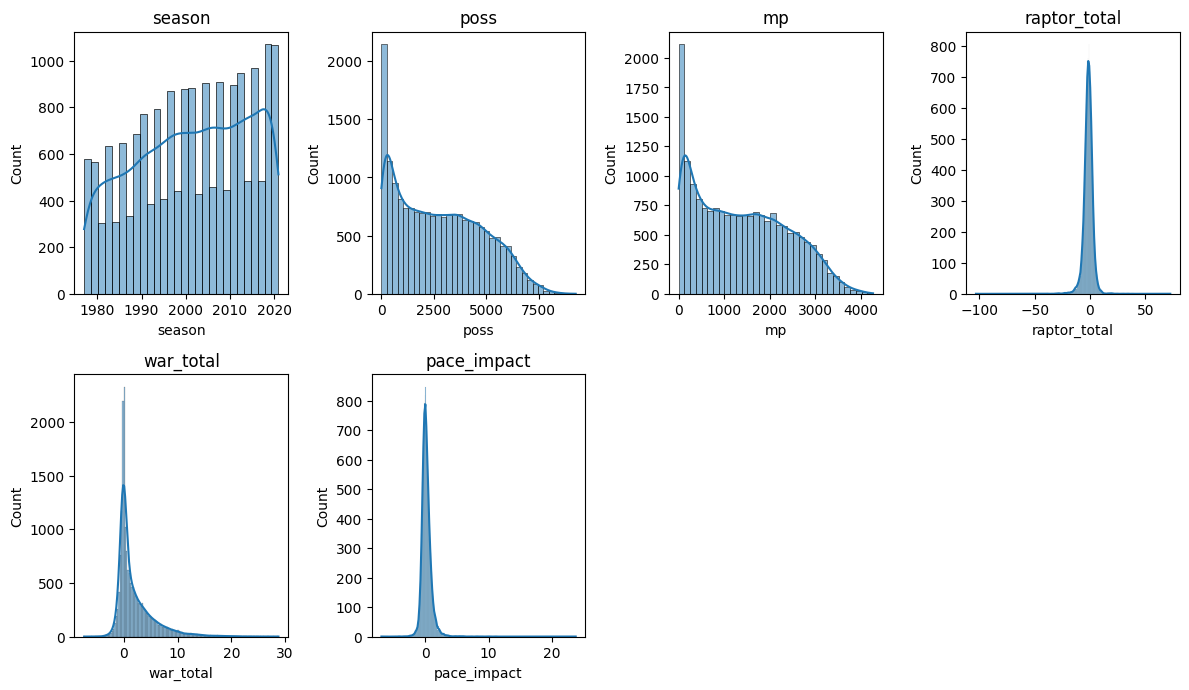

In [12]:
# get columns with numeric data types only
numeric_cols = df.select_dtypes(include='number').columns

# Plot histograms for each numeric column
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)  # Adjust grid size depending on number of features
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

We can observe the different distributions for the occurences of each feature. We can note that pace impact and raptor total, which are impact metrics, have occurences far removed from the mean (and if one were to assume a sort of normal distribution, improbable values).

what if minutes played = 0, or if they played less than an entire match that season?
what if they have zero possesions in a season?

We may consider that if they played less than a game in that season, there is not sufficient information on that player during that season. It's also wierd for players to have no poss at all.


In [13]:
print('players with less than one match in a season : ' , (df['mp']<48).sum())

df = df[df['mp']>=48]

print('players with one or none possesions in a season : ', (df['poss']<=1).sum())
df = df[df['poss']>1]


players with less than one match in a season :  1074
players with one or none possesions in a season :  0


Now let's see the target variable plotted against each feature

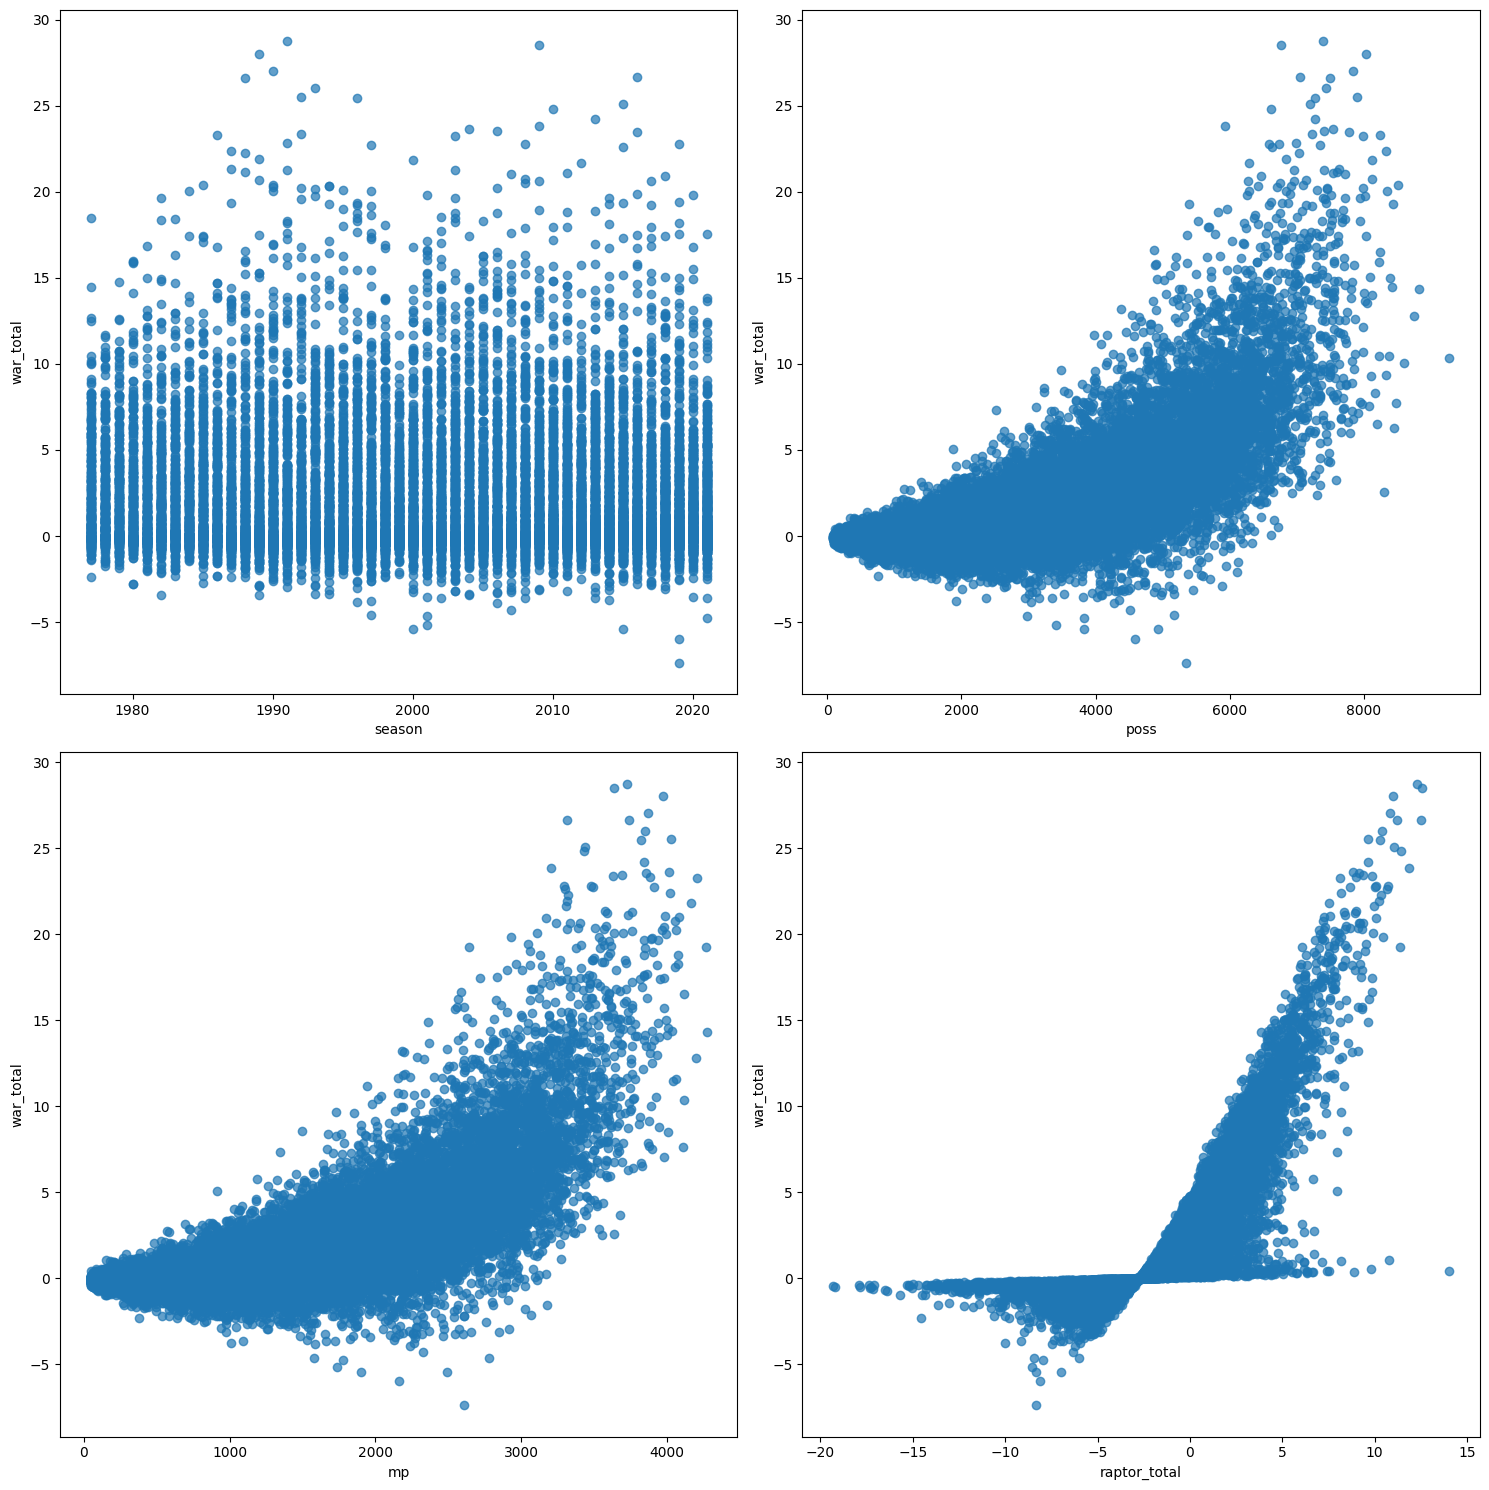

In [14]:
numeric_features = df.select_dtypes(include='number').drop(columns=['war_total']).columns

# Set up the subplots
n_features = len(numeric_features)  # Exclude 'war_total'
n_cols = 2
n_rows = 2

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes

# Plot 'war_total' against other numeric features
for feature, ax in zip(numeric_features, axs):
    if feature != 'war_total':
        ax.scatter(df[feature], df['war_total'], alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('war_total')



plt.tight_layout()
plt.show()

And the correlation matrix


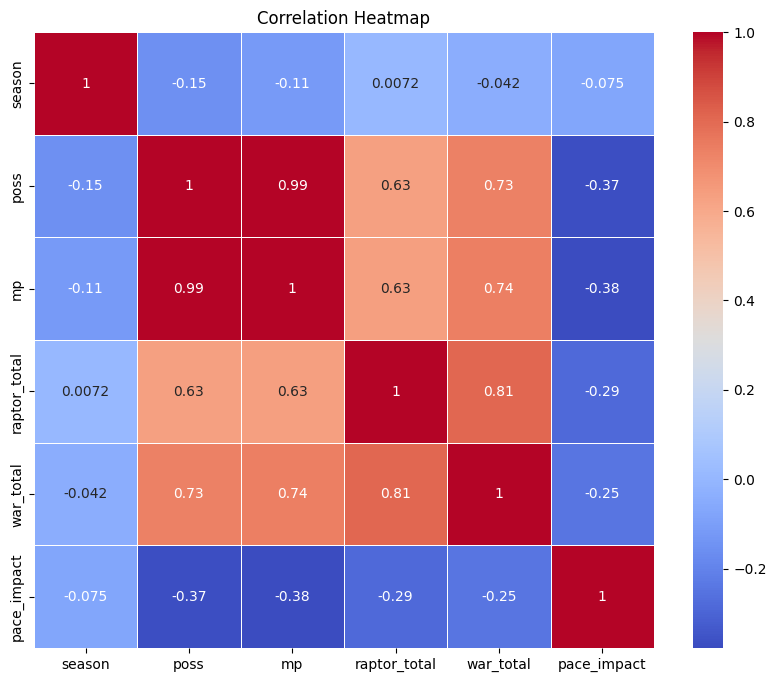

In [17]:
numeric_df = df.select_dtypes(include=["number"])
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


# feature engineering


For example if we take a look at Y vs pace impact feature, we might suspect that
there are two underlying behaviours: the one with a significant number of possesions
and another distribution for low possesion players

/tmp/ipykernel_5005/3534782363.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='pace_impact' , y='war_total',  palette='viridis', data=df, s=50, ax=axs[0])


<Axes: xlabel='pace_impact', ylabel='war_total'>

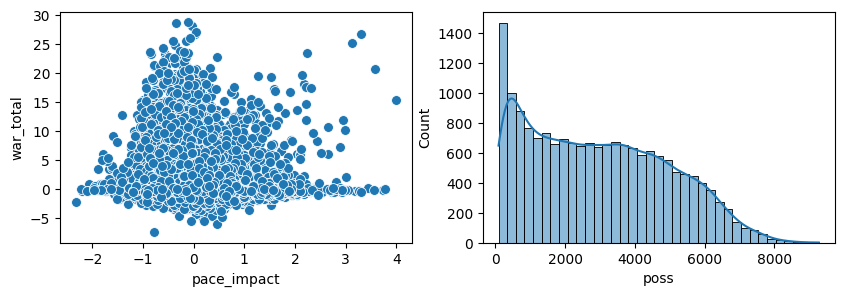

In [18]:
f,axs = plt.subplots(ncols=2, figsize = (10,3))

sns.histplot(df['poss'], kde=True, ax=axs[1])
sns.scatterplot(x='pace_impact' , y='war_total',  palette='viridis', data=df, s=50, ax=axs[0])


We will 'engineer' a new feature: 'significant possesion'.

This might be done later on with some unsupervised ML tools like k-means: for now
we will just eyeball it, choosing what seems to be a correct 'significant' number of possesions


   player_id  season  poss    mp  raptor_total  war_total  pace_impact  \
0  abdelal01    1991   640   303     -4.448526  -0.265191     0.199241   
1  abdelal01    1992  1998   959     -2.751792  -0.006893     0.485436   
2  abdelal01    1993  2754  1379     -4.443544  -1.227189     0.488266   
3  abdelal01    1994   320   159     -8.888368  -0.500600     0.511152   
4  abdelal01    1995   984   506     -5.114556  -0.615802     1.545922   

  significant_poss  
0                1  
1                1  
2                1  
3                0  
4                1  


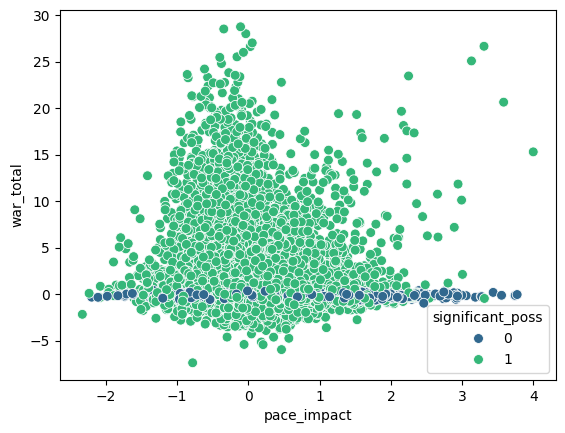

In [19]:

# I will 'clusterize' by hand, dividing the data in two groups: less and more than 500 poss
cut = 500
df['significant_poss'] = (df['poss'] >= cut).astype(int)
# Convert 'significant_poss' to categorical type
df['significant_poss'] = df['significant_poss'].astype('category')

sns.scatterplot(x='pace_impact' , y='war_total',hue='significant_poss', palette='viridis', data=df, s=50)

print(df.head(5))

In [20]:
# we can also rescale or standarize our features

def rescale(x, a=0, b=1):
    if x.max() == x.min():
        return x  # Avoid division by zero if feature is constant
    return a + (b - a) * (x - x.min()) / (x.max() - x.min())

def standardize(x):
    if x.std() == 0:
        return x  # Avoid division by zero if feature is constant
    return (x - x.mean()) / x.std()


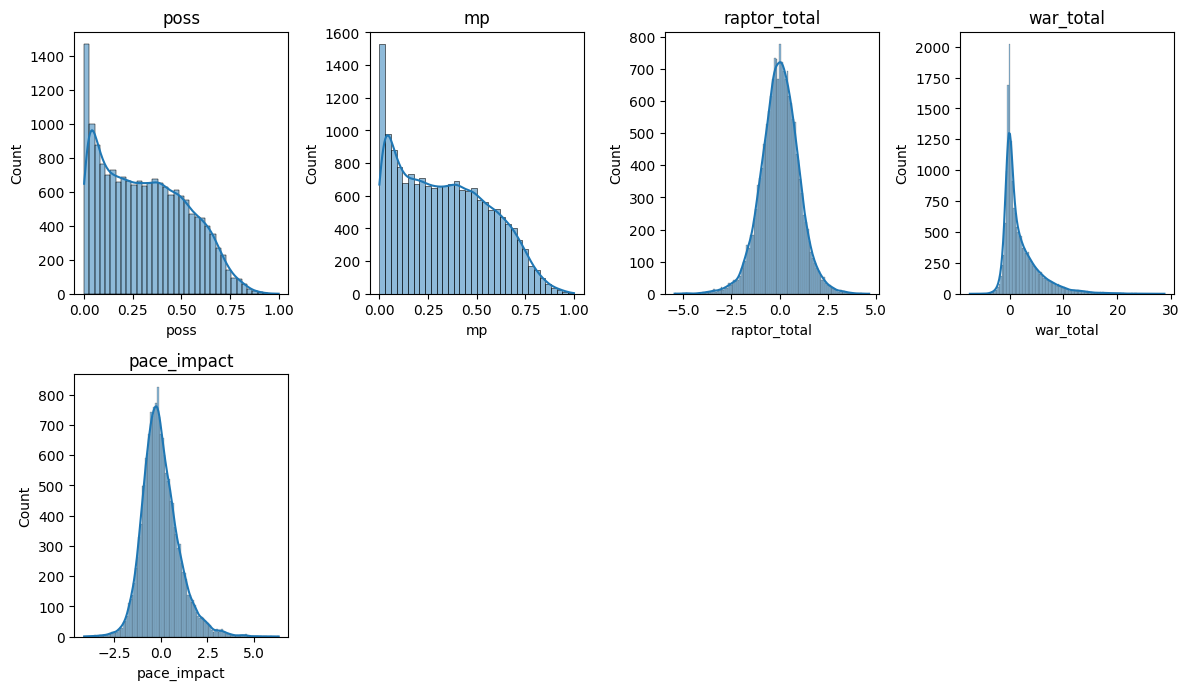

In [21]:
df_ = df.copy()
df_['mp'] = rescale(df['mp'])
df_['poss'] = rescale(df['poss'])
df_['pace_impact'] = standardize(df['pace_impact'])
df_['raptor_total'] = standardize(df['raptor_total'])
df_ = df_.drop(columns=['season'])

# Assuming your DataFrame is named df
numeric_cols = df_.select_dtypes(include='number').columns

# Plot histograms for each numeric column
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)  # Adjust grid size depending on number of features
    sns.histplot(df_[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

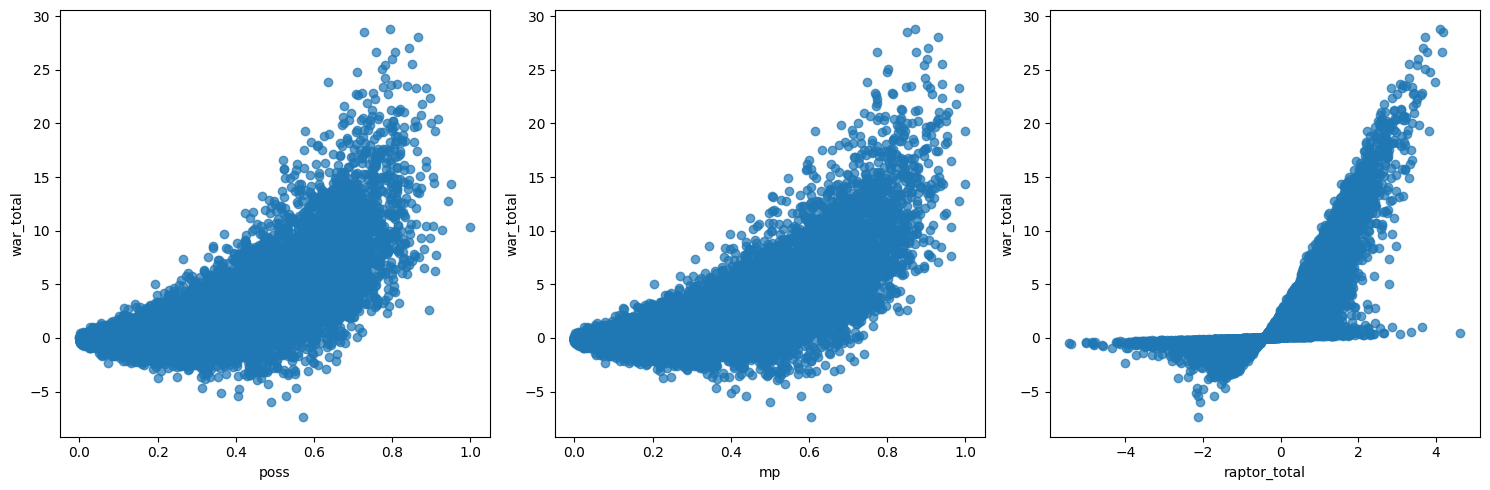

In [22]:
numeric_features = df_.select_dtypes(include='number').drop(columns=['war_total']).columns

# Set up the subplots
n_features = len(numeric_features)  # Exclude 'war_total'
n_cols = 3
n_rows = 1

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5))
axs = axs.flatten()  # Flatten the 2D array of axes

# Plot 'war_total' against other numeric features
for feature, ax in zip(numeric_features, axs):
    if feature != 'war_total':
        ax.scatter(df_[feature], df_['war_total'], alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('war_total')



plt.tight_layout()
plt.show()

# cross validation

In [23]:
X = df_[['poss', 'mp', 'raptor_total', 'pace_impact',
       'significant_poss']]
y = df_['war_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv = 5 , n_jobs= 4):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs= n_jobs)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results

# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

cross_validate_model(poly_model, X_train, y_train, f"Polynomial Model")


Polynomial Model Cross-validation RMSE Scores: [-0.01733613 -0.01744559 -0.01879667 -0.01814611 -0.017478  ]
Polynomial Model Mean RMSE Score: -0.01784050084635373
Polynomial Model Cross-validation R² Scores: [0.99997485 0.99997391 0.99997242 0.99997322 0.99997577]
Polynomial Model Mean R² Score: 0.9999740356869271



{'fit_time': array([0.15561891, 0.15457463, 0.10486984, 0.12553477, 0.12576485]),
 'score_time': array([0.0126667 , 0.01275682, 0.01628041, 0.01544428, 0.01079226]),
 'test_neg_root_mean_squared_error': array([-0.01733613, -0.01744559, -0.01879667, -0.01814611, -0.017478  ]),
 'test_r2': array([0.99997485, 0.99997391, 0.99997242, 0.99997322, 0.99997577])}

In [24]:
# now if we filter for only high posession data:
df_high = df_[df_['significant_poss']==1]
X = df_high[['poss', 'mp',  'raptor_total','pace_impact']]
y = df_high['war_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv = 5 , n_jobs= 4):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs= n_jobs)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results

# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

cross_validate_model(poly_model, X_train, y_train, f"Polynomial Model")

Polynomial Model Cross-validation RMSE Scores: [-0.02017444 -0.02032578 -0.01821525 -0.01888063 -0.01855509]
Polynomial Model Mean RMSE Score: -0.01923023740554919
Polynomial Model Cross-validation R² Scores: [0.99997079 0.99996871 0.9999766  0.99997366 0.99997191]
Polynomial Model Mean R² Score: 0.9999723342156113



{'fit_time': array([0.10504937, 0.08344531, 0.07604837, 0.0813992 , 0.04403591]),
 'score_time': array([0.00972891, 0.01267147, 0.01229906, 0.00878143, 0.00992894]),
 'test_neg_root_mean_squared_error': array([-0.02017444, -0.02032578, -0.01821525, -0.01888063, -0.01855509]),
 'test_r2': array([0.99997079, 0.99996871, 0.9999766 , 0.99997366, 0.99997191])}

In [25]:
# only high posession data and with only raptor_total stat
df_high = df_[df_['significant_poss']==1]
X = df_high[['raptor_total']]
y = df_high['war_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv = 5 , n_jobs= 4):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs= n_jobs)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results

# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

cross_validate_model(poly_model, X_train, y_train, f"Polynomial Model")

Polynomial Model Cross-validation RMSE Scores: [-1.35039652 -1.33933883 -1.34844756 -1.31220288 -1.27703076]
Polynomial Model Mean RMSE Score: -1.325483311641447
Polynomial Model Cross-validation R² Scores: [0.86912231 0.86415787 0.87174963 0.87279192 0.86692724]
Polynomial Model Mean R² Score: 0.86894979342499



{'fit_time': array([0.01636076, 0.01706409, 0.02528596, 0.01320148, 0.01181674]),
 'score_time': array([0.00947356, 0.00991917, 0.01363754, 0.00798893, 0.00654912]),
 'test_neg_root_mean_squared_error': array([-1.35039652, -1.33933883, -1.34844756, -1.31220288, -1.27703076]),
 'test_r2': array([0.86912231, 0.86415787, 0.87174963, 0.87279192, 0.86692724])}

# test data check

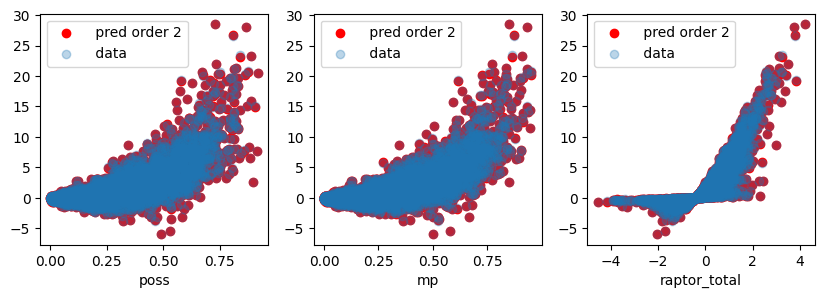

In [26]:
X = df_[['poss', 'mp', 'raptor_total', 'pace_impact',
       'significant_poss']]
y = df_['war_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X_train, y_train)

f,axs = plt.subplots(ncols = 3 , figsize = (10,3))

y_pred = poly_model.predict(X_test)
axs[0].scatter(X_test['poss'] , y_pred , label = f' pred order {2}', color = 'r')
axs[0].set_xlabel('poss')
axs[1].scatter(X_test['mp'] , y_pred , label = f' pred order {2}', color = 'r')
axs[1].set_xlabel('mp')
axs[2].scatter(X_test['raptor_total'] , y_pred , label = f' pred order {2}', color = 'r')
axs[2].set_xlabel('raptor_total')

axs[0].scatter(X_test['poss'] , y_test , label = ' data' , alpha = 0.3)

axs[1].scatter(X_test['mp'] , y_test , label = ' data' , alpha = 0.3)

axs[2].scatter(X_test['raptor_total'] , y_test , label = ' data' , alpha = 0.3)
axs[0].legend()
axs[1].legend()
axs[2].legend()


# What about the season? Categorical data to ordinal data



In [27]:
# In this case, a player may have many seasons played. We are interested in what number of season
# the player is experiencing. So, we can generate ordinal data (season 0, 1, 2, 3, ...) just by operating
# the following way:  'ordinal season' = 'present season' - 'oldest season' for each distinct player id

df_['season'] = df['season']
df_['oldest_season'] = df_.groupby('player_id')['season'].transform('min')
df_['delta_season'] = df_['season'] - df_['oldest_season']
df_

,player_id,poss,mp,raptor_total,war_total,pace_impact,significant_poss,season,oldest_season,delta_season
0,abdelal01,0.060213,0.060398,-0.948202,-0.265191,0.065219,1,1991,1991,0
1,abdelal01,0.208079,0.215775,-0.435511,-0.006893,0.535263,1,1992,1991,1
2,abdelal01,0.290396,0.315253,-0.946696,-1.227189,0.539910,1,1993,1991,2
3,abdelal01,0.025370,0.026291,-2.289758,-0.500600,0.577498,0,1994,1991,3
4,abdelal01,0.097670,0.108479,-1.149451,-0.615802,2.276990,1,1995,1991,4
...,...,...,...,...,...,...,...,...,...,...
18548,zubaciv01,0.132622,0.132875,-1.537493,-1.141160,0.795896,1,2017,2017,0
18549,zubaciv01,0.085366,0.085741,0.331051,0.531968,0.249717,1,2018,2017,1
18550,zubaciv01,0.245862,0.244197,0.230189,1.217134,-0.135425,1,2019,2017,2
18551,zubaciv01,0.365854,0.378494,1.800828,6.224207,-0.935659,1,2020,2017,3


In [28]:
# only high posession data and with only raptor_total stat
df_high = df_[df_['significant_poss']==1]
X = df_high[['raptor_total', 'delta_season']]
y = df_high['war_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv = 5 , n_jobs= 4):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs= n_jobs)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results

# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

cross_validate_model(poly_model, X_train, y_train, f"Polynomial Model")

Polynomial Model Cross-validation RMSE Scores: [-1.33608056 -1.32283307 -1.33225444 -1.29686551 -1.26586026]
Polynomial Model Mean RMSE Score: -1.3107787666267858
Polynomial Model Cross-validation R² Scores: [0.87188254 0.86748542 0.87481138 0.87574822 0.8692451 ]
Polynomial Model Mean R² Score: 0.8718345347925022



{'fit_time': array([0.02516174, 0.03113151, 0.03244829, 0.02817082, 0.01784277]),
 'score_time': array([0.01312137, 0.01087976, 0.00780344, 0.00853038, 0.00926661]),
 'test_neg_root_mean_squared_error': array([-1.33608056, -1.32283307, -1.33225444, -1.29686551, -1.26586026]),
 'test_r2': array([0.87188254, 0.86748542, 0.87481138, 0.87574822, 0.8692451 ])}

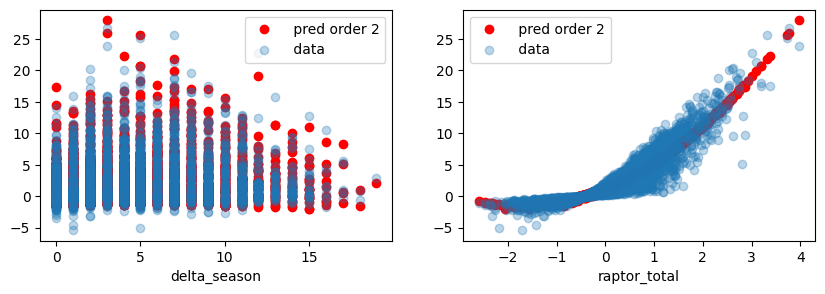

In [29]:
# only high posession data and with only raptor_total stat
df_high = df_[df_['significant_poss']==1]
X = df_high[['raptor_total', 'delta_season']]
y = df_high['war_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X_train, y_train)

f,axs = plt.subplots(ncols = 2 , figsize = (10,3))

y_pred = poly_model.predict(X_test)

axs[0].scatter(X_test['delta_season'] , y_pred , label = f' pred order {2}', color = 'r')
axs[0].set_xlabel('delta_season')

axs[1].scatter(X_test['raptor_total'] , y_pred , label = f' pred order {2}', color = 'r')
axs[1].set_xlabel('raptor_total')

axs[0].scatter(X_test['delta_season'] , y_test , label = ' data' , alpha = 0.3)
axs[1].scatter(X_test['raptor_total'] , y_test , label = ' data' , alpha = 0.3)

axs[0].legend()
axs[1].legend()
